# Identifying the product in a user complaint
author : Alfonso Farruggia

### EXPLORATION, ANALYSIS, MODELLING & OPERATIONALIZATION
The complaints_users table contains all the complaints made by users and the type of product the user identified in the complaint. The goal is to use the text data (“complaint_text) provided by the user to design an ML algorithm to identify the product it’s related to (“main-product”, “sub-product”)

## Exploratory Data Analysis:
Explore the text data and the different products.

In [1]:
import pandas as pd
c_users = pd.read_csv('../data/complaints_users.csv')
products = pd.read_csv('../data/products.csv')

/home/alfonso/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### **What are your preliminary observations?**
_We can observe that the dataset is composed of 383066 entries(a). the users have complained about all the products(b). The most complained is the product with id 26 whereas the lowest has id 97 (c,d). To be noted the huge difference between the highest value and the lowest value of the number of complaints. This aspect needs to be explored in depth._ 

In [2]:
# c_users.head()

In [3]:
# products.head()

In [4]:
print("a. Training entries:",c_users.shape[0])
unique_products = c_users.groupby('PRODUCT_ID')["COMPLAINT_ID"].nunique().sort_values(ascending=False).reset_index()
print("b. Product in training set:",unique_products.shape[0]," - Products in DB:",products.shape[0])
print("c. Most complained is the product with id",unique_products["PRODUCT_ID"][0],"with ",unique_products["COMPLAINT_ID"][0],"reclaim/s")
print("d. Most complained is the product with id",unique_products["PRODUCT_ID"][unique_products.shape[0]-1],"with ",unique_products["COMPLAINT_ID"][unique_products.shape[0]-1],"reclaim/s")

a. Training entries: 383066
b. Product in training set: 98  - Products in DB: 98
c. Most complained is the product with id 26 with  89994 reclaim/s
d. Most complained is the product with id 97 with  1 reclaim/s


### **Is the text data clean?**
_Just showing the first comments, we can assume that the text needs to be cleaned. We can note that there are Uppercase letters, repeated dots, digit, special-characters, obfuscated data. All of these need to be processed in order to have a better representation of the text in the vectorial space._

**The data needs to be preprocessed**

In [5]:
print("1)",c_users["COMPLAINT_TEXT"][0])
# print("2)",c_users["COMPLAINT_TEXT"][1])
# print("3)",c_users["COMPLAINT_TEXT"][2])
# print("4)",c_users["COMPLAINT_TEXT"][3])
# print("5)",c_users["COMPLAINT_TEXT"][4])

1) XXXX  and Transunion are reporting incorrectly that I am 120 days past due on loans with the XXXX  - partial account numbers XXXX ; XXXX ; XXXX ; XXXX.. These accounts reflect a {$0.00} balance and a {$0.00} past due. I have contacted the two bureaus and requested these coding errors be corrected. This incorrect reporting is harming my credit score. It is  impossible to be past due on accounts that have a {$0.00} balance and {$0.00} past due.


### **Should we use all the products?**

_Before to answer this question, we have to answer a question like this:_

**Do you have enough data to well-represent all the classes (products) with the dataset?**

_Answer to this question is not easy, but there are some heuristic rules in literature, for example, one of these says: a model needs X independent training examples for each class where X is equal a number of classes multiplied by a factor, for example, 10. In our case, if we want to map 98 classes (products) in our model, each class has to have about 980 comments._

_Let's do some analysis using statistical parameters like mean, median, and quartile. This analysis will help us (and the company) to understand if we have to keep all the dataset or prune some entries of it._

_How we have seen before, there are classes in the dataset represented by only a few occurrences, as for example for the product with id 97 that has only 1 comment. We can manage this like an outlier because it probably introduces noise into the model._ 

_The next question is:_ **How many entries do we have to exclude from the dataset in order to all classes are well represented into the dataset?**

_For example, if we want to follow the before the heuristic rule, we can conduct evaluations using statistical parameter like mean, median and quartile and, after, check if the condition is respected:_

* Filtering by the mean: 21 classes are kept (77 classes are excluded). Each class is represented by more than 3908 comments. 89% of comments are used to train the model.
* Filtering by the median: 49 classes are kept (49 classes are excluded). Each class is represented by more then 864 comments. 97% of comments are used to train the model.
* Filtering by the quartile (approx. value): 61 classes are kept (37 classes are excluded). Each class is represented by more then 432 comments. 97% of comments are used to train the model.

_Now we should answer this question:_ **Would the company lose part of the information in order to keep a more accurate model?***

Mean over complained products 3908.8367346938776
Numner classes 21 over 98
Total comments 321748 over 383066  -  83.99283674353767 %


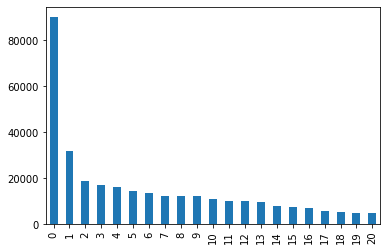

In [6]:
mean_products = unique_products["COMPLAINT_ID"].mean()
print("Mean over complained products",(mean_products))
h_prod_good_mean = unique_products[unique_products["COMPLAINT_ID"]>mean_products]["COMPLAINT_ID"]
print("Numner classes",h_prod_good_mean.shape[0],"over",products.shape[0])
h_prod_good_mean.plot.bar()
print("Total comments",sum(h_prod_good_mean),"over",c_users.shape[0]," - ",sum(h_prod_good_mean)/c_users.shape[0]*100,"%")

Median over complained products 864.0
Numner classes 49 over 98
Total comments 372129 over 383066  -  97.14487842826041 %


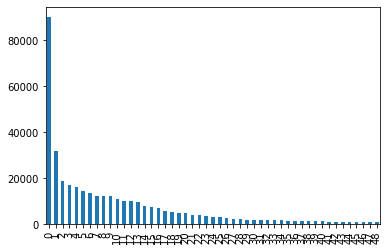

In [7]:
median_products = unique_products["COMPLAINT_ID"].median()
print("Median over complained products",(median_products))
h_prod_good_median = unique_products[unique_products["COMPLAINT_ID"]>median_products]["COMPLAINT_ID"]
print("Numner classes",h_prod_good_median.shape[0],"over",products.shape[0])
h_prod_good_median.plot.bar()
print("Total comments",sum(h_prod_good_median),"over",c_users.shape[0]," - ",sum(h_prod_good_median)/c_users.shape[0]*100,"%")

Quartile over complained products 432.0
Numner classes 61 over 98
Total comments 380260 over 383066  -  99.26748915330518 %


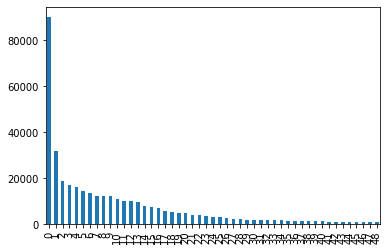

In [8]:
quartile_products = unique_products["COMPLAINT_ID"].median()/2 # approx value!
print("Quartile over complained products",(quartile_products))
h_prod_good_quartile = unique_products[unique_products["COMPLAINT_ID"]>quartile_products]["COMPLAINT_ID"]
print("Numner classes",h_prod_good_quartile.shape[0],"over",products.shape[0])
h_prod_good_median.plot.bar()
print("Total comments",sum(h_prod_good_quartile),"over",c_users.shape[0]," - ",sum(h_prod_good_quartile)/c_users.shape[0]*100,"%")

## Feature Engineering
Utilizing your findings from part a) and some creativity, create some NLP features. Explain your reasoning behind the features.

**We assume that the company is happy if we filter by MEAN because the company wants to focus on the most complained products. (Actually, I'm happy because I reduce the training time)**

This assumption reduces the number of products from 98 to 21. For future convenience, I map a new PRODUCT_ID into the dataset, in this way the NEW_PRODUCT_ID starts from 0 to 20. This will help us in the hot_vector creation via to_convert() keras function for the multi-label classification.

Before to move the training into the model, each comment is preprocessed using DataCleaning class. The **DataCleaning** class does the following steps:
* Replace contractions
* Remove not ascii code
* Lowercase
* Remove punctuation
* Manage currency, numbers and date (obfuscate)

In [9]:
import numpy as np
p_id = unique_products[unique_products["COMPLAINT_ID"]>mean_products]["PRODUCT_ID"]
dataset = c_users[c_users["PRODUCT_ID"].isin(p_id)]
dataset.loc[:,"NEW_PRODUCT_ID"] = None
                                        
for p_id_i in range(len(p_id)):
    indexes = dataset["PRODUCT_ID"] == p_id[p_id_i]
    dataset["NEW_PRODUCT_ID"][indexes] = p_id_i

    
_r_map = dataset[['PRODUCT_ID', 'NEW_PRODUCT_ID']]
mapping = [_r_map['PRODUCT_ID'].unique(),_r_map['NEW_PRODUCT_ID'].unique()]

/home/alfonso/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/alfonso/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/alfonso/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [10]:
import re
from tqdm import tqdm
from nltk.corpus import stopwords
import sys  
sys.path.insert(0, '../code')
from data_cleaning import DataCleaning

In [11]:
dc = DataCleaning()
texts = [] 
for line in tqdm(dataset["COMPLAINT_TEXT"], total=dataset.shape[0]): 
    texts.append(dc.normalize(line))

100%|██████████| 321748/321748 [19:20<00:00, 277.33it/s]


## Model Selection/Validation

Create an ML model which identifies the product in the complaint.

**Explain model/parameter selection and assess its quality.**

* The model is set to accept a dictionary composed of _MAX_WORDS_ number to include all the possible words in comments in the training/classification process.
* The max number of words allowed in a comment is 150 _(MAX_SEQ_LENGTH)_ , this could be a scenario if the complaining message coming from a chat or micro-blogging platform.
* I decide to use [Glove](https://nlp.stanford.edu/projects/glove/) to create the embedding matrix and each word is represented by a vector of 50 features (for better performance this number should be increased).

In [12]:
MAX_WORDS = 120000 # max words for tokenizer
MAX_SEQ_LENGTH = 150 # max length of each entry comment ( num of words)
GLOV_EMBEDDING_DIM = 50 # Glove dimensions 
GLOVE_DIR = "../data/glove.6B/glove.6B."+str(GLOV_EMBEDDING_DIM)+"d.txt"

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(texts)

In [14]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index), "MAX_SEQ_LENGTH",MAX_SEQ_LENGTH)

Vocabulary size: 138116 MAX_SEQ_LENGTH 150


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_seq = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQ_LENGTH)

**Why have you chosen this feature/model combination?**

* After the pre-processing, the dataset is composed of 21 products. This number is the number of the output layer.
* The network will produce a float point vector of 21 values, one for each product. Given a comment to be classified, the highest value in the output vector denotes the most probable product associated with that comment.
* Dataset is split in 75% training and 25% validation
* The hidden layer is composed of 42 neurons ( 2 x output neurons)
* The NN is composed of :
    * 3 layers : LSTM(42) -> DENSE(42) -> Dense(21)
        * The activation fuction of last layer is the softmax, this function normalize the values between 0 to 1
        * Dropout is used to reduce overfitting (20% of neurones are dropped out randomically)
        * LSTM permits to keep the status (memory) between RNN
    * The input of LSTM is a Embedding computed with Glove
* To test the perfomance, I measure the accuracy and the loss in 2 epochs .

In [16]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(dataset["NEW_PRODUCT_ID"].values)

In [17]:
NN_OUTPUT = labels.shape[1]
NN_DROPOUT = 0.2
NN_INPUT = NN_OUTPUT * 2
NAME_MODEL = "model_"+str(NN_OUTPUT)+"_products.h5"
EPOCHS = 2
BATCH_SIZE = 32

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_seq, labels, test_size=0.25, random_state=1)

In [19]:
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix = np.random.random((len(word_index) + 1, GLOV_EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
from tensorflow.keras.layers import *
sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           GLOV_EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQ_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [21]:
x = LSTM(NN_INPUT, return_sequences=True,name='lstm_complaint_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(NN_DROPOUT)(x)
x = Dense(NN_INPUT, activation="relu")(x)
x = Dropout(NN_DROPOUT)(x)
preds = Dense(NN_OUTPUT, activation="sigmoid")(x)

In [22]:
from tensorflow.keras.models import Model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 150, 50)           6905850   
_________________________________________________________________
lstm_complaint_layer (LSTM)  (None, 150, 42)           15624     
_________________________________________________________________
global_max_pooling1d (Global (None, 42)                0         
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42)                0     

In [23]:
history = model.fit(x_train, y_train, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val))

Train on 241311 samples, validate on 80437 samples
Epoch 1/2
241311/241311 [==============================] - 828s 3ms/sample - loss: 0.1351 - accuracy: 0.9553 - val_loss: 0.1118 - val_accuracy: 0.9578
Epoch 2/2
241311/241311 [==============================] - 887s 4ms/sample - loss: 0.1135 - accuracy: 0.9577 - val_loss: 0.1055 - val_accuracy: 0.9585


In [24]:
model.save("../artifacts/"+NAME_MODEL)

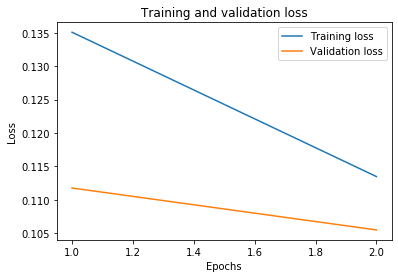

In [25]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

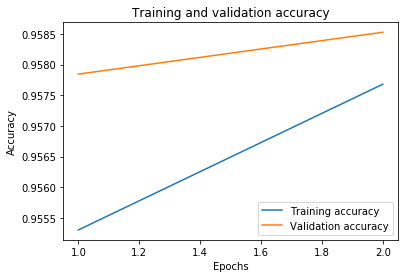

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

## What would you make differently if you had more time?

* To normalize the number of comments for each class in order to have a balanced distribution of comments over the classes. For example, product 26 has 89994 comments, can we reduce this number without losing the semantic representation of the class?
* To improve the Datacleaning class with more accurate ad-hoc functions to preprocess each comment, for example, to detect special information like Bank Account Number, Companies Name, etc.
* To evaluate different network configurations, what's happening with a Convolution Layer?
* To test the model with k-folder cross-validation.
* To build the confusion-matrix to evaluate its derivative parameters

## Manual Test direcly on notebook

In [32]:
def test_comment(text):
    dc = DataCleaning()
    text = dc.normalize(text)
    good = [text]
    _tokenized = tokenizer.texts_to_sequences(good)
    _testing = pad_sequences(_tokenized, maxlen=MAX_SEQ_LENGTH)
    _y_testing = model.predict(_testing, verbose = 1)
    return np.argmax(_y_testing)

In [33]:
new_product_id = test_comment("XXXX  and Transunion are reporting incorrectly that I am 120 days past due on loans with the XXXX  - partial account numbers XXXX ; XXXX ; XXXX ; XXXX.. These accounts reflect a {$0.00} balance and a {$0.00} past due. I have contacted the two bureaus and requested these coding errors be corrected. This incorrect reporting is harming my credit score. It is  impossible to be past due on accounts that have a {$0.00} balance and {$0.00} past due")

1/1 [==============================] - 0s 12ms/sample


In [34]:
def get_product_name(new_product_id):
    p_id = mapping[0][mapping[1]==new_product_id][0]
    return products["MAIN_PRODUCT"][products["PRODUCT_ID"]==p_id].values[0]

In [35]:
name = get_product_name(0)

In [36]:
print(name)

Credit reporting, credit repair services, or other personal consumer reports
